# Producing a final year project allocation


In [1]:
import warnings
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matching.games import StudentAllocation

warnings.filterwarnings("ignore")
%matplotlib inline

---
## Cleaning the data

In order to use the `matching` library's SPA algorithm(s), we require the data to be "clean".

This is effectively just taking the attributes (columns) of interest and removing any erroneous instances (rows).

In [2]:
raw_students = pd.read_csv("../../data/students.csv")
raw_projects = pd.read_csv("../../data/projects.csv")
raw_supervisors = pd.read_csv("../../data/supervisors.csv")


### Students

Valid students must have:
- a unique identifier
- a unique ranking (so that supervisors may have a strict preference over them)
- strict, unique, preferences over some non-empty subset of the projects

In our case, we know that students make up to 25 selections and the choice columns are numbered 1 through 25.

In [3]:
raw_students.columns

Index(['name', 'rank', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24'],
      dtype='object')

In [4]:
n_choices = 25
choices = list((str(x) for x in range(n_choices)))


In [5]:
students = raw_students.copy()
students = students.dropna(subset=choices, how="all")
students.columns = ["student_number", "rank"] + [int(x) for x in choices]

assert (
    students["student_number"].nunique() == students["rank"].nunique() == len(students)
)

# students.to_csv("data/students.csv", index=False)


In [6]:
students.head()


,student_number,rank,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,190000,55,H1,S1,P2,U1,T0,V2,Q0,F0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,190002,24,W1,C0,T1,I0,K2,K1,G1,U1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,190003,36,K2,X1,T1,R1,W1,R2,K2,J0,...,A0,O0,L0,D2,NaN,NaN,NaN,NaN,NaN,NaN
4,190004,73,K1,V1,R2,G2,Y2,G2,W0,K0,...,P1,T2,N1,I1,K0,P3,X1,F0,NaN,NaN
5,190005,15,P1,S0,C0,Z0,L0,H2,D0,U0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


See if no students were lost:

In [7]:
len(raw_students) - len(students)

3

### Projects

Projects need a unique code, a supervisor and a capacity. We drop any project that is missing any of these items.

In [8]:
projects = raw_projects.copy()
projects = projects.dropna()
projects.columns = ["project_code", "project_capacity", "supervisor_name"]
projects["supervisor_name"] = projects["supervisor_name"].apply(
    lambda x: x.strip().upper()
)

assert projects["project_code"].nunique() == len(projects)

In [9]:
projects.head()


,project_code,project_capacity,supervisor_name
0,A0,7,A
1,A1,2,A
2,A2,3,A
3,B0,3,B
4,B1,5,B


See if any projects were lost:

In [10]:
len(raw_projects) - len(projects)

0

### Supervisors

Each supervisor requires a unique name and a capacity. We drop any supervisor without either of these things.

In [11]:
supervisors = raw_supervisors.copy()
supervisors = supervisors.dropna()
supervisors.columns = ["supervisor_name", "supervisor_capacity"]
supervisors["supervisor_name"] = supervisors["supervisor_name"].apply(
    lambda x: x.strip().upper()
)

assert supervisors["supervisor_name"].nunique() == len(supervisors)

# supervisors.to_csv("data/supervisors.csv", index=False)


In [12]:
supervisors.head()


,supervisor_name,supervisor_capacity
0,A,3
1,B,6
2,C,3
3,D,2
4,E,1


Verify no supervisors were lost:

In [13]:
len(supervisors) == len(raw_supervisors)


True

In [14]:
len(supervisors)

26

---
## Creating the dictionaries

With the now clean data, Python dictionaries can be created to pass to the `matching` library.

### Capacities and affiliations

We only consider supervisors with a non-zero capacity:

In [15]:
supervisor_names = supervisors[supervisors["supervisor_capacity"] > 0][
    "supervisor_name"
].values

project_codes = projects["supervisor_name"].values


Create two dictionaries for the projects: one to keep track of capacities and the other for affiliations with a supervisor.

With both dictionaries, a project is only added if both their capacity and the capacity of their supervisor is non-zero.

In [16]:
project_capacities, project_supervisors = {}, {}
for _, (project, capacity, supervisor) in projects.iterrows():
    if capacity > 0 and supervisor in supervisor_names:
        project_supervisors[project] = supervisor
        project_capacities[project] = capacity
    else:
        print(
            project,
            capacity,
            supervisor,
            supervisors[supervisors["supervisor_name"] == supervisor][
                "supervisor_capacity"
            ].iloc[0],
        )


Create another dictionary to keep track of supervisor capacities (only included if they have at least one valid project).

In [17]:
supervisor_capacities = {}
for _, (supervisor, capacity) in supervisors.iterrows():
    if supervisor in project_supervisors.values():
        supervisor_capacities[supervisor] = capacity


### Preferences

We now create the preference dictionaries; the cornerstone of the matching game.

As previously stated, students must have a strict, unique preference of some non-empty subset of the projects. This means that if a student ranks no projects, they are excluded from the game. Also, if a student ranks the same project more than once, their highest ranking of that project is taken only.

In [18]:
student_prefs = {}
for _, (student_number, _, *prefs) in students.iterrows():
    prefs_ = []
    for project in prefs:
        if project in project_supervisors and project not in prefs_:
            prefs_.append(project)

    if prefs_:
        student_prefs[student_number] = prefs_


In order to make the game as fair as possible, each student is idependently allocated a unique rank in the cohort. This complete ranking allows the supervisors to draw their preference list from the same source.

In this particular game, each supervisor must rank all (and only) those students who have ranked at least one of their projects.

If a student has ranked multiple projects from the same supervisor, they still only appear once in the supervisor's preference list. As with students, if a supervisor's preference list is empty (i.e. none of their projects were ranked by any student) then they are excluded from the game.

In [19]:
sorted_students = students.sort_values("rank", ascending=True)["student_number"].values
supervisor_prefs = {}

for supervisor in supervisor_capacities:

    preferences = []
    supervisor_projects = projects[projects["supervisor_name"] == supervisor][
        "project_code"
    ].values

    for student in sorted_students:
        prefs = student_prefs[student]
        if set(prefs).intersection(supervisor_projects):
            preferences.append(student)

    if preferences:
        supervisor_prefs[supervisor] = preferences


---
## Final clean up

### Removing extra players from the game

We now have to go back through `supervisor_capacities` to catch where unranked supervisors should be excluded.

Note also that if a supervisor has not been ranked, none of their projects have either. We should also remove these projects from our dictionaries `project_capacities` and `project_supervisors`.

In [20]:
unranked_supervisors = set(project_supervisors.values()).difference(
    supervisor_prefs.keys()
)
unranked_supervisors


set()

In [21]:
unranked_projects = set(project_capacities.keys()).difference(
    (project for prefs in student_prefs.values() for project in prefs)
)
unranked_projects


{'M0'}

In [22]:
iter_project_supervisors = dict(project_supervisors)
for project, supervisor in iter_project_supervisors.items():
    if supervisor in unranked_supervisors:
        del project_supervisors[project]
        del project_capacities[project]
        try:
            del supervisor_capacities[supervisor]
        except KeyError:
            print(supervisor, "already deleted.")


In [23]:
for project in unranked_projects:
    try:
        del project_supervisors[project]
        del project_capacities[project]
    except KeyError:
        print(project, "already deleted.")


### Checking and adjusting capacities

There are some stipulations on the capacities of projects and their supervisors:

1. Each project's capacity must be no larger than that of its supervisor.

2. Each supervisor's capacity must be:
    - At least as large as its largest project's capacity.
    - No larger than the sum of its projects' capacities.

We begin by reducing the capacities of too-large projects.

This means that no supervisor will have to increase their capacity for the sake of a single project, and we don't need to worry about the first point in (2).

In [24]:
for project, capacity in project_capacities.items():
    supervisor = project_supervisors[project]
    supervisor_capacity = supervisor_capacities[supervisor]

    if capacity > supervisor_capacity:
        print(
            f"{project} has a capacity of {capacity} but",
            f"{supervisor} has capacity {supervisor_capacity}.",
        )
        project_capacities[project] = supervisor_capacity


A0 has a capacity of 7 but A has capacity 3.
C0 has a capacity of 4 but C has capacity 3.
C2 has a capacity of 8 but C has capacity 3.
D1 has a capacity of 6 but D has capacity 2.
E0 has a capacity of 4 but E has capacity 1.
E1 has a capacity of 8 but E has capacity 1.
E2 has a capacity of 6 but E has capacity 1.
F0 has a capacity of 6 but F has capacity 4.
G0 has a capacity of 8 but G has capacity 6.
K0 has a capacity of 3 but K has capacity 1.
K1 has a capacity of 8 but K has capacity 1.
N2 has a capacity of 6 but N has capacity 3.
P0 has a capacity of 3 but P has capacity 1.
P2 has a capacity of 3 but P has capacity 1.
Q0 has a capacity of 7 but Q has capacity 2.
R0 has a capacity of 8 but R has capacity 1.
R1 has a capacity of 8 but R has capacity 1.
R2 has a capacity of 4 but R has capacity 1.
U1 has a capacity of 6 but U has capacity 3.
U2 has a capacity of 7 but U has capacity 3.
V0 has a capacity of 4 but V has capacity 2.
V1 has a capacity of 8 but V has capacity 2.
W0 has a c

Now we can make sure that no supervisor is providing more spaces than they're offering through their projects.

In [25]:
supervisor_projects = defaultdict(list)
for project, supervisor in project_supervisors.items():
    supervisor_projects[supervisor].append(project)

for supervisor, capacity in supervisor_capacities.items():
    projects_ = supervisor_projects[supervisor]
    project_capacities_ = [project_capacities[project] for project in projects_]

    if capacity > sum(project_capacities_):
        print(
            f"{supervisor} has capacity {capacity} but their projects",
            f"{', '.join(projects_)} have a total capacity of",
            f"{sum(project_capacities_)}.",
        )
        supervisor_capacities[supervisor] = sum(project_capacities_)


H has capacity 8 but their projects H0, H1, H2 have a total capacity of 5.
M has capacity 5 but their projects M1 have a total capacity of 1.
O has capacity 4 but their projects O0, O1 have a total capacity of 3.


---
## Playing the game

Now that we have formulated our players according to the rules of the game, we are ready to play it.

The `matching` library has an implementation of the SPA algorithm which takes the dictionaries we've built as parameters. From there, the game can be solved to be student- or supervisor-optimal. We'll be using the former.

In [26]:
game = StudentAllocation.create_from_dictionaries(
    student_prefs,
    supervisor_prefs,
    project_supervisors,
    project_capacities,
    supervisor_capacities,
)

matching = game.solve(optimal="student")
assert game.check_validity()
assert game.check_stability()


In [27]:
matching


{A0: [190097], A1: [190035], A2: [190037], B0: [190071, 190039, 190070], B1: [190048, 190090], B2: [190011], C0: [190038], C1: [190093], C2: [190089], D0: [190023], D1: [190076], D2: [], E0: [190044], E1: [], E2: [], F0: [190025, 190047], F1: [190062, 190054], G0: [190072], G1: [190058], G2: [190056, 190004, 190077, 190040], H0: [190087, 190094], H1: [190082], H2: [190043, 190046], I0: [190060, 190041, 190034], I1: [190053, 190086, 190078], I2: [190066, 190029], J0: [190020, 190050, 190080], J1: [190042, 190007, 190027, 190015], J2: [190049], K0: [], K1: [], K2: [190014], L0: [190057, 190091], L1: [190059], M1: [190013], N0: [190096], N1: [190055], N2: [190084], O0: [190051], O1: [190052, 190064], P0: [], P1: [190088], P2: [], P3: [], Q0: [190065, 190019], R0: [], R1: [], R2: [190010], S0: [190005, 190079], S1: [190000, 190069, 190068, 190067, 190031], T0: [190016, 190061], T1: [190009, 190006, 190085, 190092], T2: [190036], U0: [190033], U1: [190017, 190081], U2: [], V0: [190073], V1:

---
## Analysis

The raw matching provided above is less than easy to read, let alone interpret. So, let's observe the data in a different form using some visualisation tools.

In [28]:
plt.style.use("seaborn-colorblind")


### Supervisors

Using the `matching.Game` instance we've created, we can extract the utilisation of our supervisors.

In [29]:
supervisor_free_spaces = {
    supervisor: supervisor.capacity - len(supervisor.matching)
    for supervisor in game.supervisors
}

supervisor_utilisation = {
    supervisor: len(supervisor.matching) / supervisor.capacity
    for supervisor in game.supervisors
}


Text(0.5, 1.0, 'Supervisor free spaces')

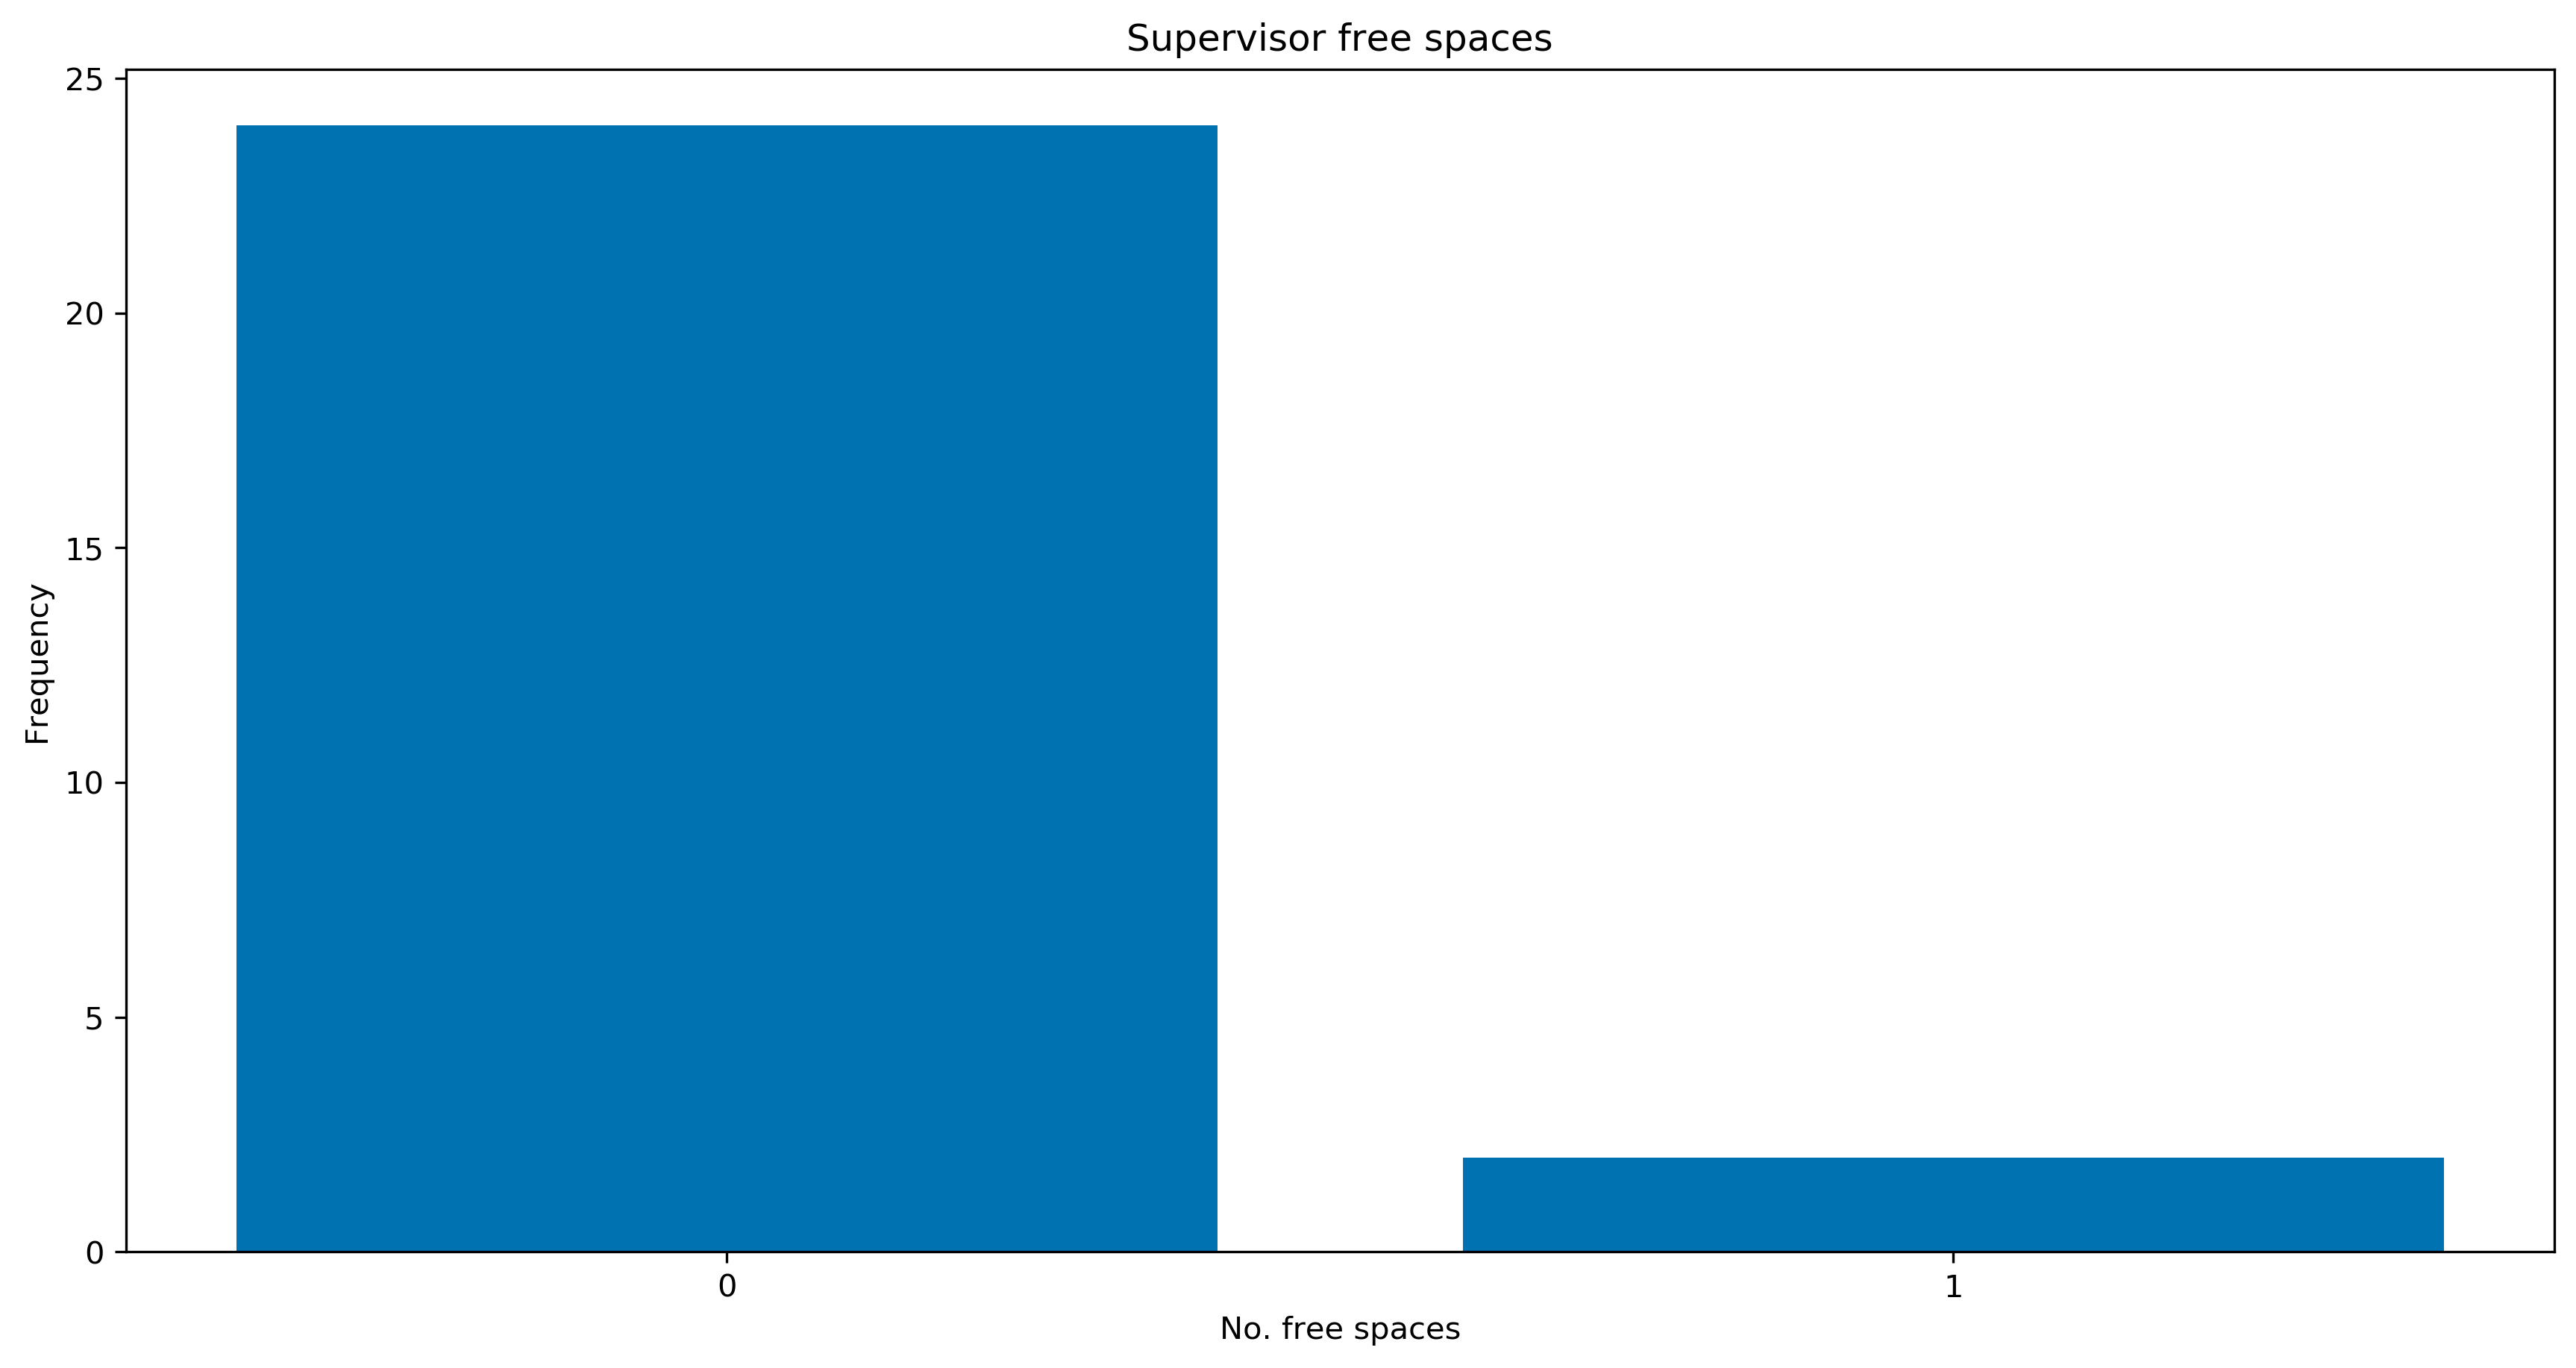

In [30]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

data = Counter(supervisor_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set_xlabel("No. free spaces")
ax.set_ylabel("Frequency")
ax.set_xticks(range(max(data.keys()) + 1))
ax.set_title("Supervisor free spaces")


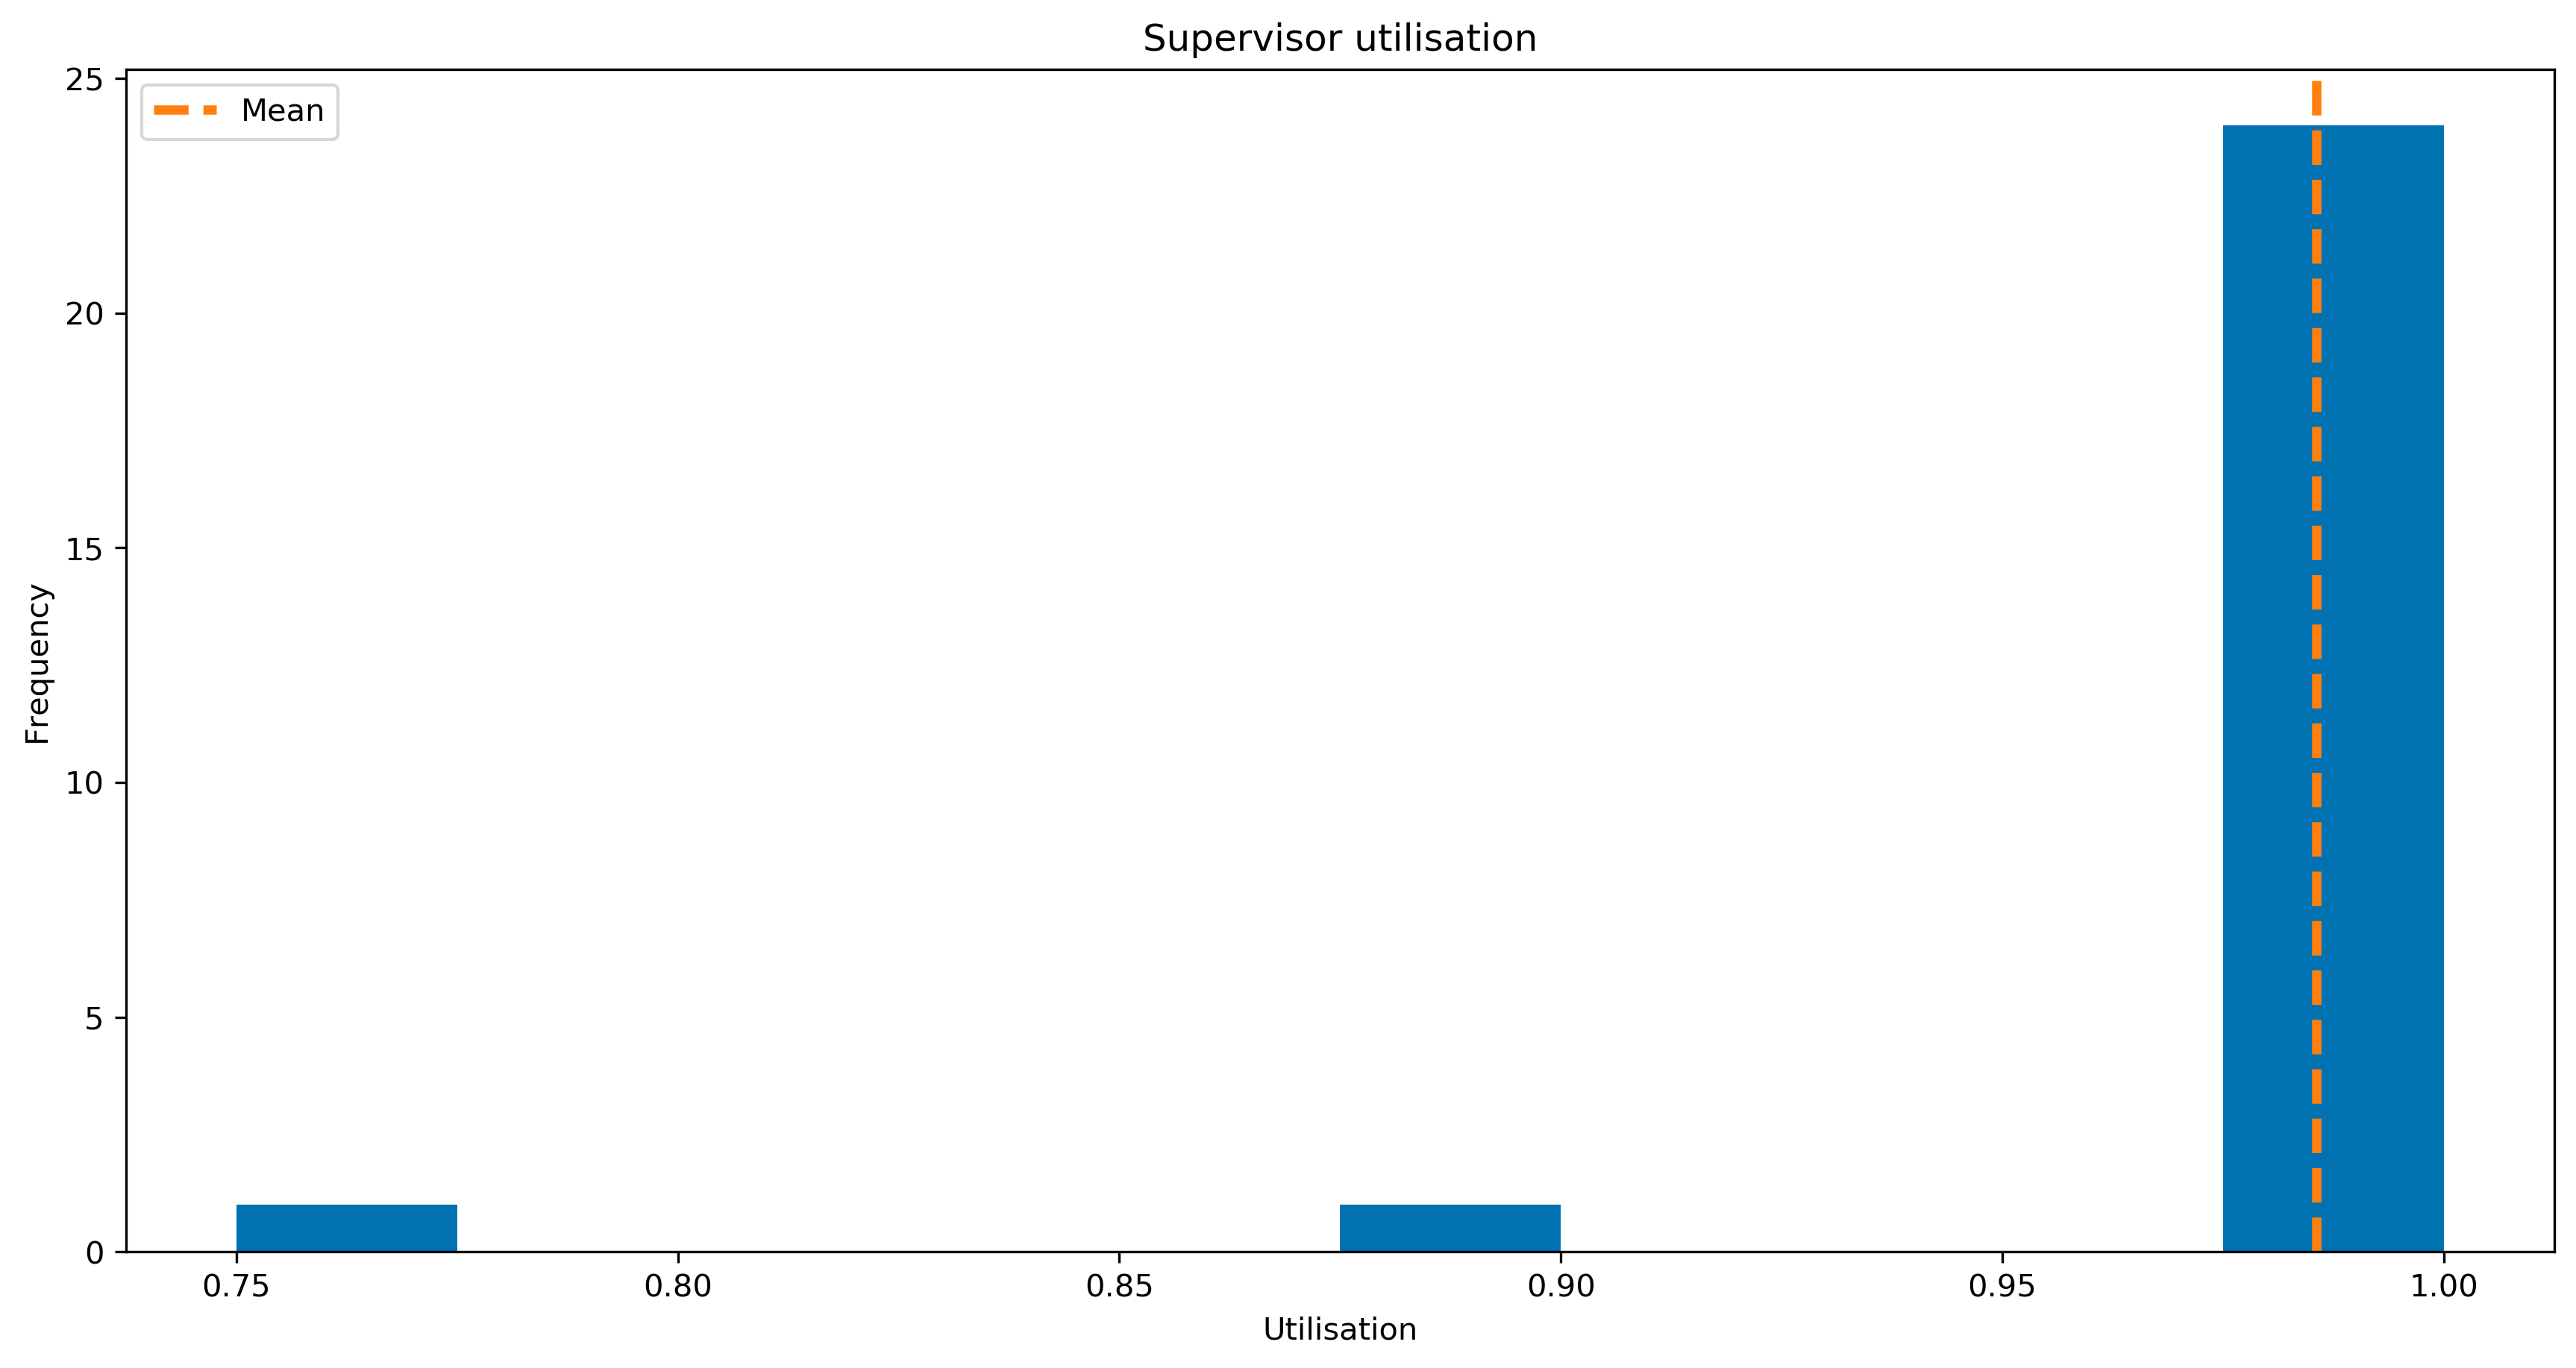

In [31]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = supervisor_utilisation.values()
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(np.mean(list(values)), *ylims, "tab:orange", "dashed", label="Mean", lw=3)
ax.set_ylim(*ylims)

ax.set_xlabel("Utilisation")
ax.set_ylabel("Frequency")
ax.set_title("Supervisor utilisation")
ax.legend()


In [32]:
supervisor_df = pd.concat(
    (pd.Series(supervisor_free_spaces), pd.Series(supervisor_utilisation)), axis=1
)
supervisor_df.columns = ["free_spaces", "utilisation"]
supervisor_df.describe().iloc[1:, :]

,free_spaces,utilisation
mean,0.076923,0.985577
std,0.271746,0.053932
min,0.000000,0.750000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


### Projects

We can do the same visualisation with the projects that were included in the game. This is a nice way to observe the quantity of excess projects offered to students.

In [33]:
project_free_spaces = {
    project.name: project.capacity - len(project.matching) for project in game.projects
}

project_utilisation = {
    project.name: len(project.matching) / project.capacity for project in game.projects
}


Text(0.5, 1.0, 'Project free spaces')

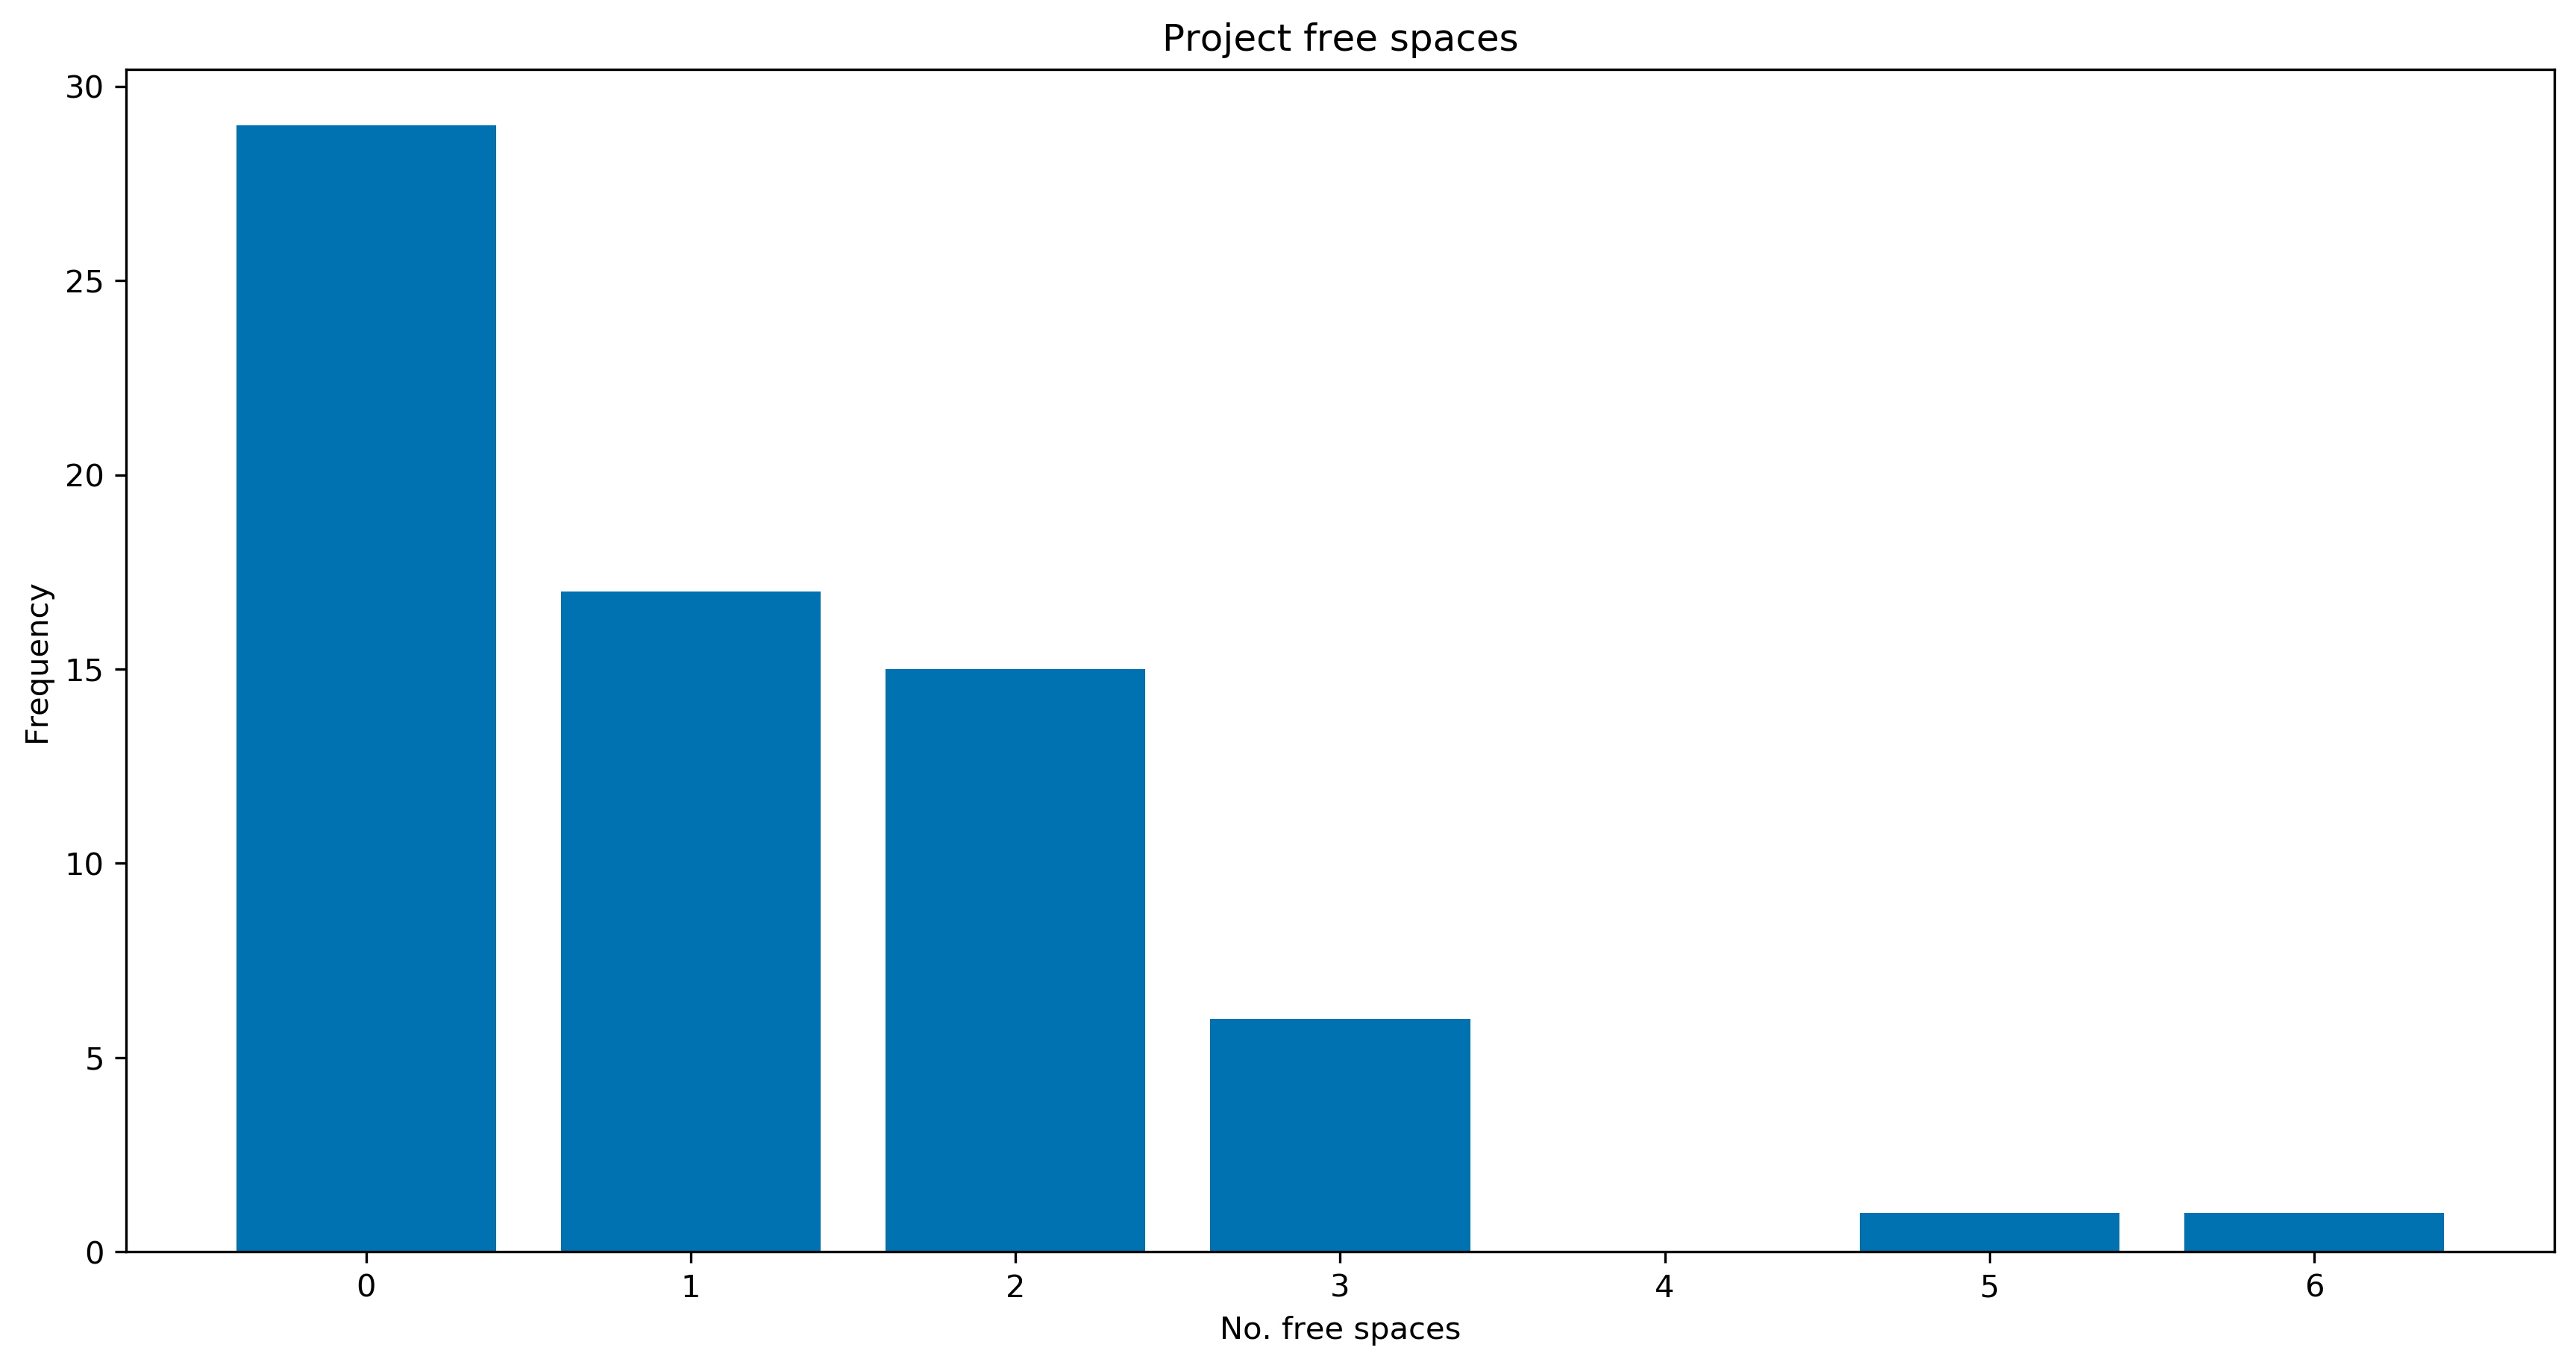

In [34]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

data = Counter(project_free_spaces.values())
ax.bar(data.keys(), data.values())

ax.set_xlabel("No. free spaces")
ax.set_ylabel("Frequency")
ax.set_xticks(range(max(data.keys()) + 1))
ax.set_title("Project free spaces")


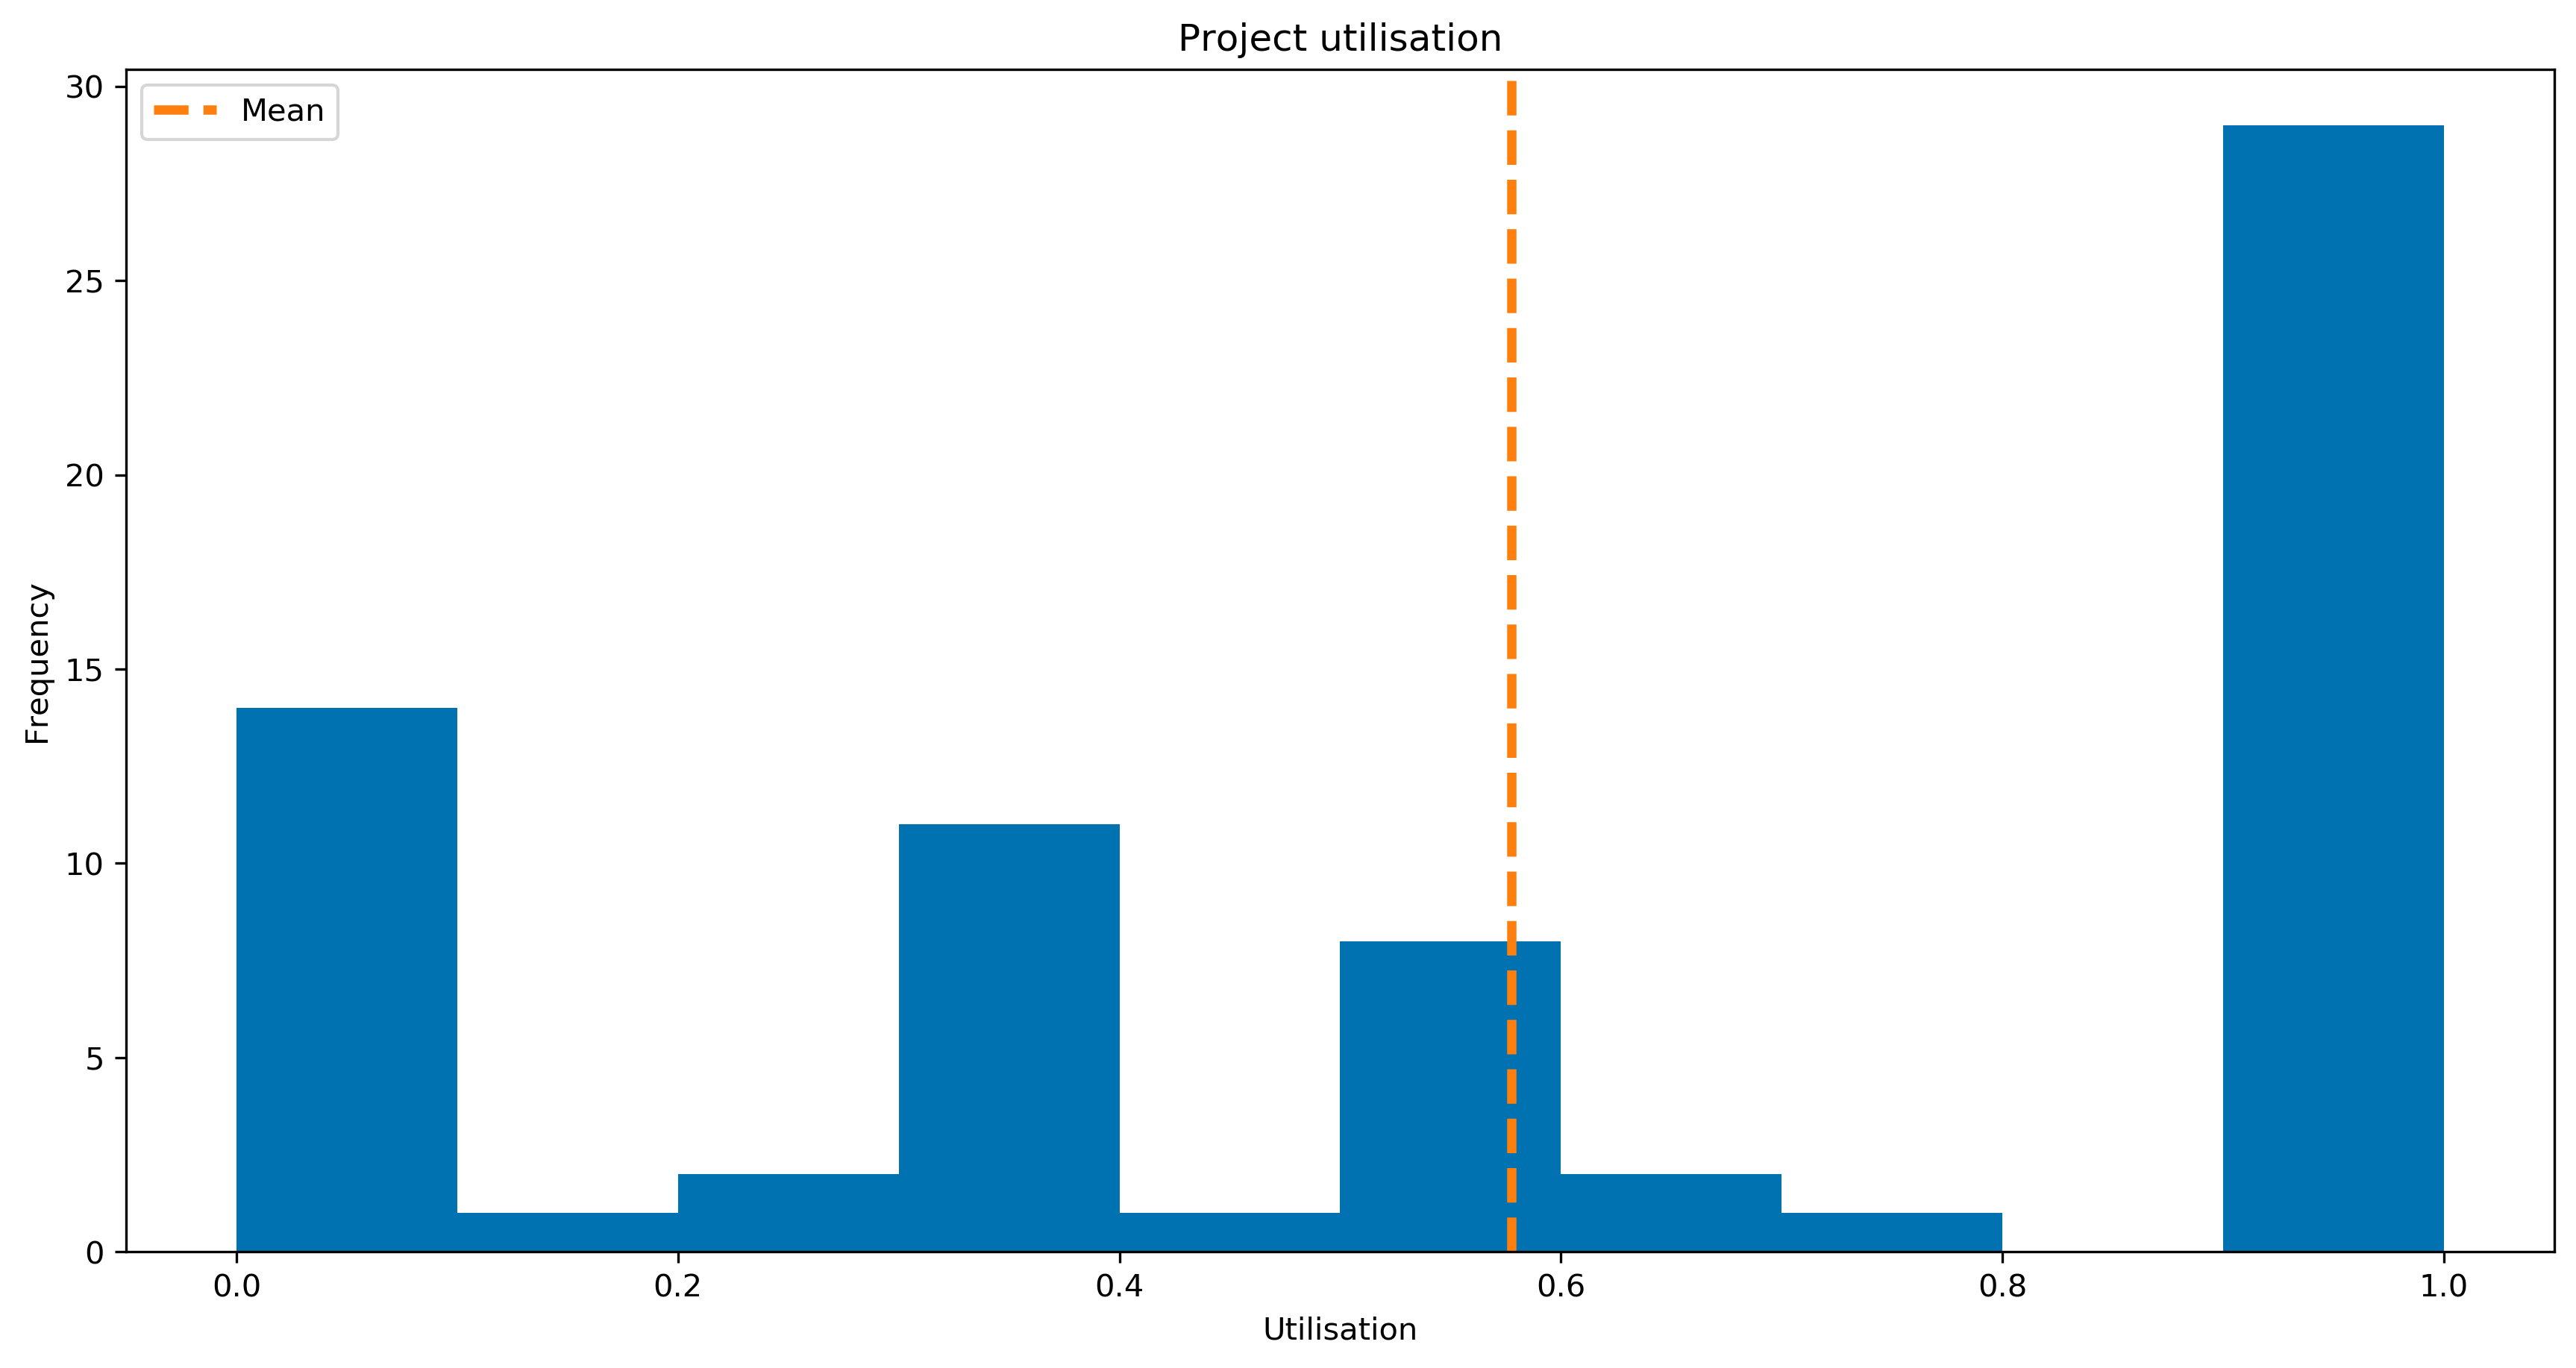

In [35]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = project_utilisation.values()
ax.hist(values)

ylims = ax.get_ylim()
ax.vlines(np.mean(list(values)), *ylims, "tab:orange", "dashed", label="Mean", lw=3)
ax.set_ylim(*ylims)

ax.set_xlabel("Utilisation")
ax.set_ylabel("Frequency")
ax.set_title("Project utilisation")
ax.legend()


In [36]:
project_df = pd.concat(
    (pd.Series(project_free_spaces), pd.Series(project_utilisation)), axis=1
)
project_df.columns = ["free_spaces", "utilisation"]
project_df.describe().iloc[1:, :]


,free_spaces,utilisation
mean,1.101449,0.577484
std,1.261942,0.402171
min,0.000000,0.000000
25%,0.000000,0.333333
50%,1.000000,0.500000
75%,2.000000,1.000000
max,6.000000,1.000000


### Students

Arguably, the most valuable analysis is of the students and their matchings. To do this, we will need to "invert" the matching found by the library.

In [37]:
invert_matching = {}
matching_rank = []
for project, students_ in matching.items():
    for student in students_:
        invert_matching[student.name] = project.name
        matching_rank.append(student.pref_names.index(project.name))


This inverted matching can now be converted to a `pandas.DataFrame` object that behaves as a table of data.

In this form, it is easy to link students between the matching data and the original as well as being able to extract those students who remain unmatched.

In [38]:
df_matching = pd.DataFrame(
    {
        "student_number": list(invert_matching.keys()),
        "project_code": list(invert_matching.values()),
        "preference": matching_rank,
    }
)

order = students.set_index("student_number").index
df_matching = df_matching.set_index("student_number").reindex(order).reset_index()

df_matching["rank"] = raw_students["rank"]
unassigned_students = df_matching[df_matching["preference"].isnull()]
assigned_students = df_matching[df_matching["preference"].notnull()]
assigned_students["preference"] = assigned_students["preference"].astype(int)


In [39]:
assigned_students.head()


,student_number,project_code,preference,rank
0,190000,S1,1,55
1,190002,W1,0,66
2,190003,X1,1,24
3,190004,G2,3,36
4,190005,S0,1,73


In [40]:
unassigned_students


,student_number,project_code,preference,rank
7,190008,NaN,NaN,46
17,190018,NaN,NaN,19
20,190021,NaN,NaN,49
25,190028,NaN,NaN,67
27,190030,NaN,NaN,76
60,190063,NaN,NaN,14
71,190074,NaN,NaN,20
72,190075,NaN,NaN,68


The matching that has been found is mathematically fair and optimal for all the students in the game.

However, it is still nice to know how "good" it is.

Text(0.5, 1.0, 'Student matching preferences')

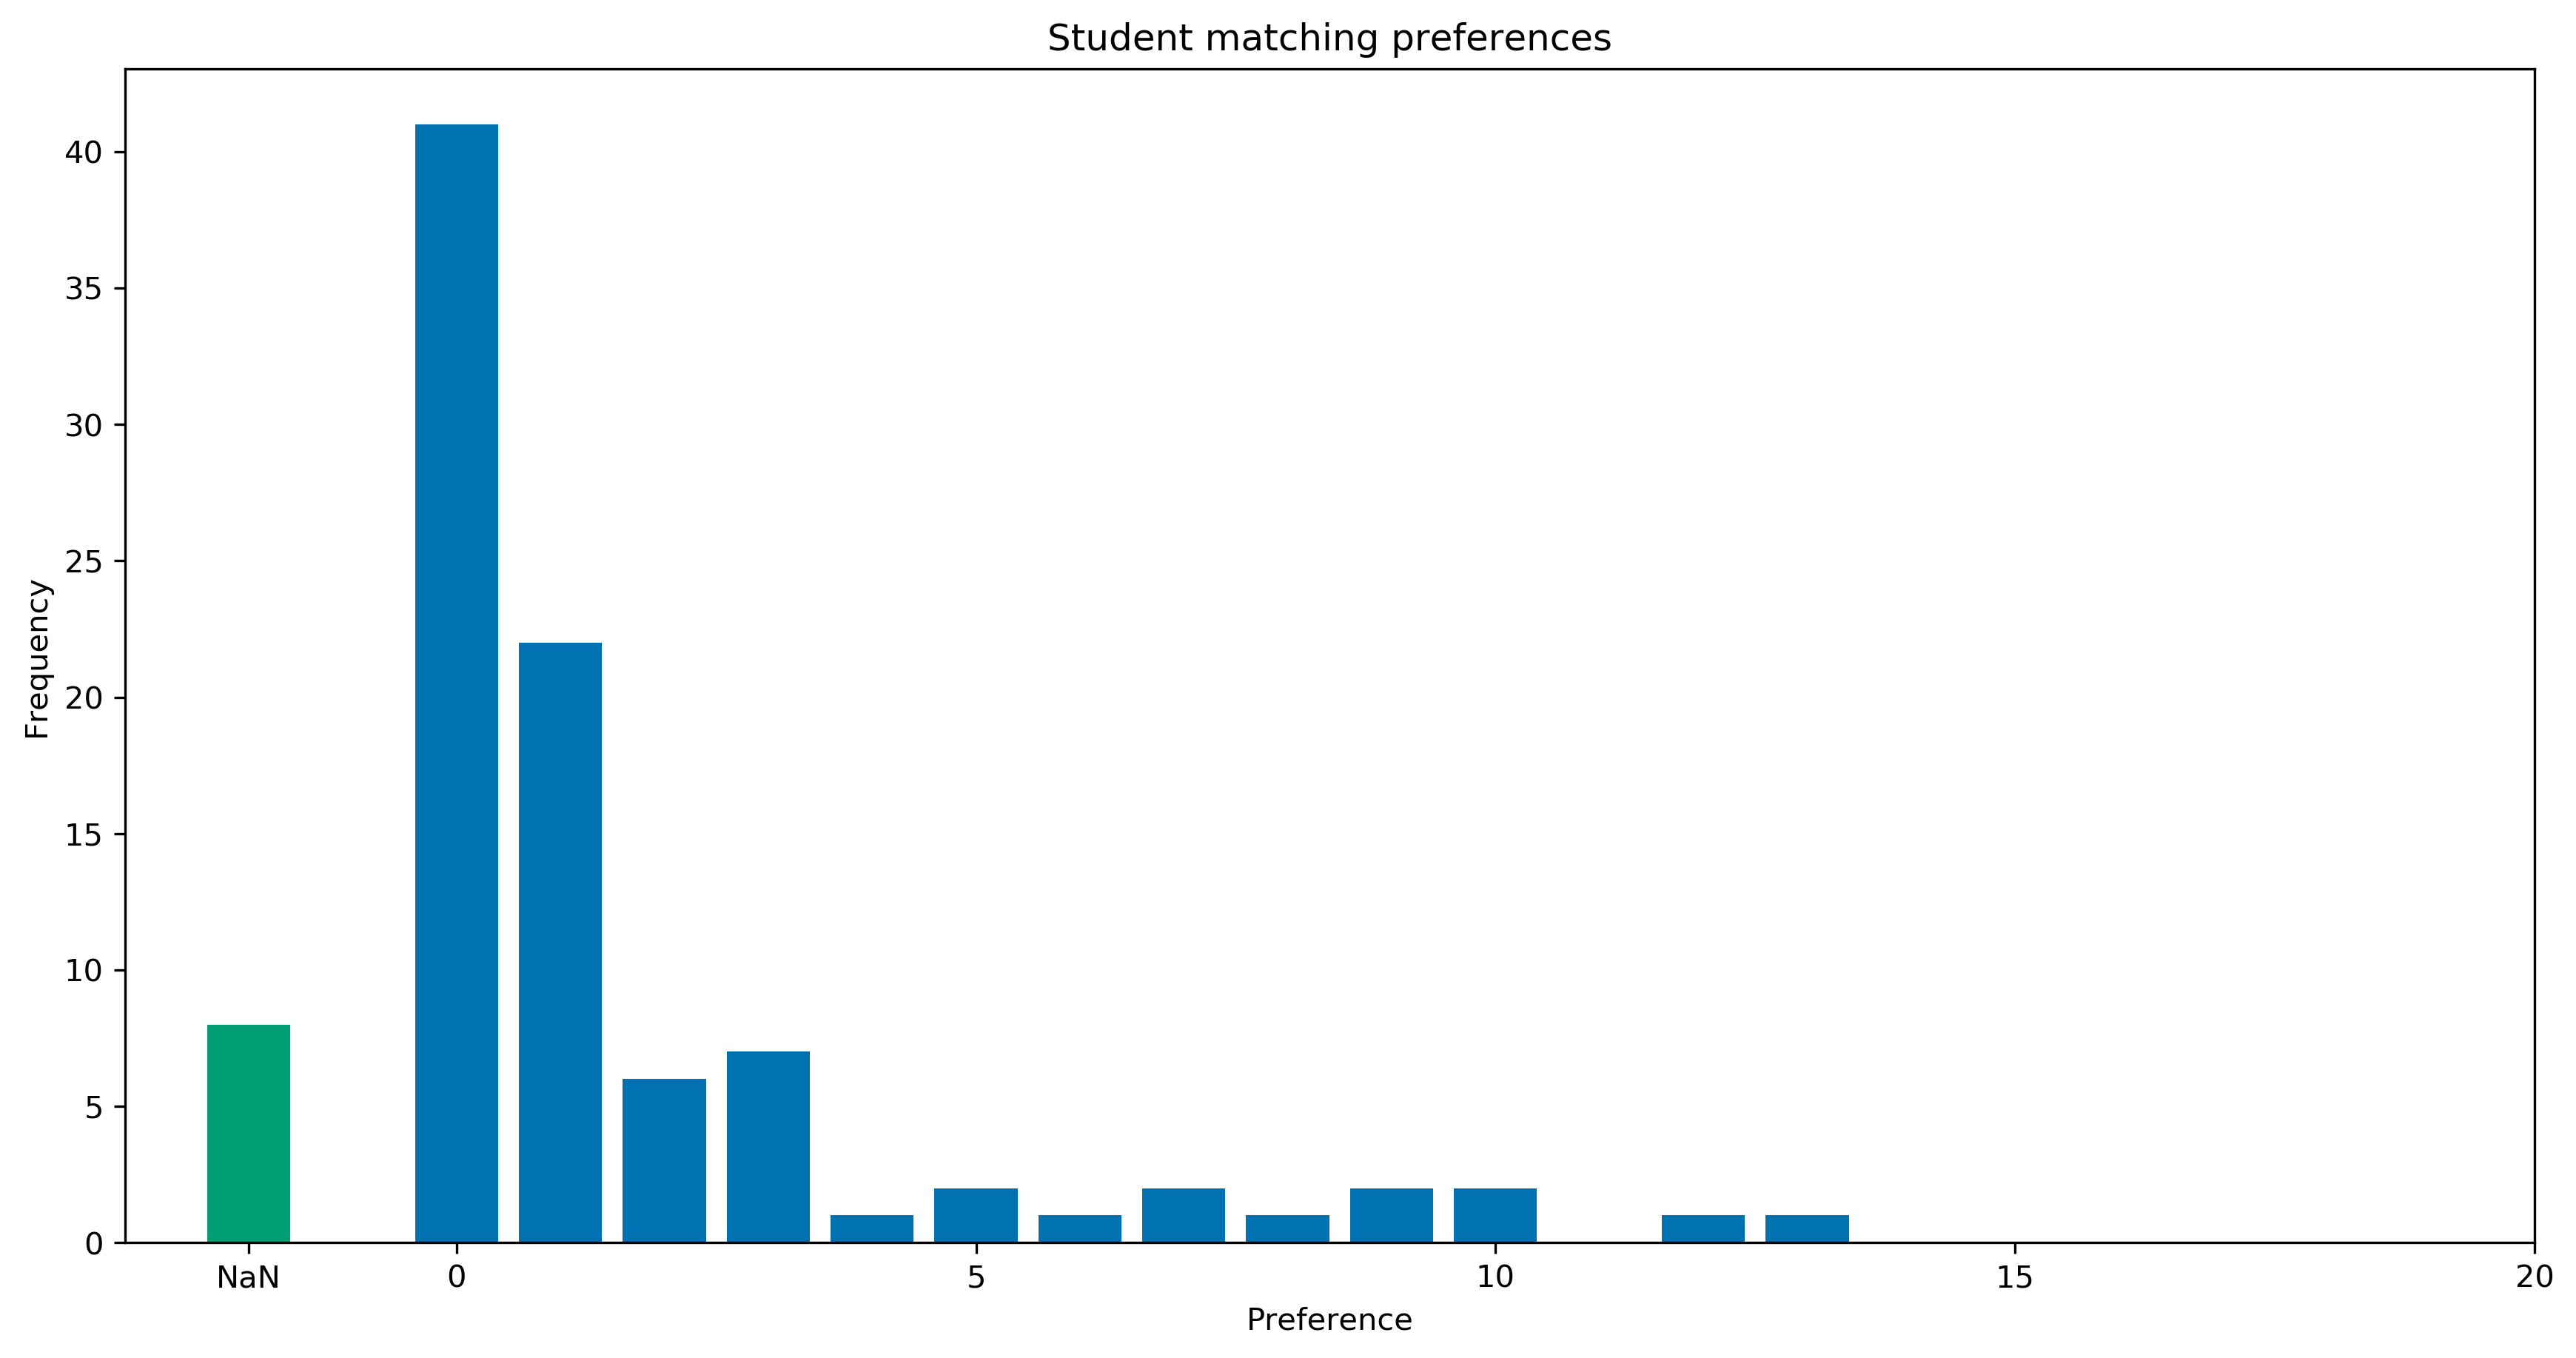

In [41]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

values = Counter(assigned_students["preference"])
ax.bar(values.keys(), values.values())
ax.bar(-2, len(unassigned_students))

ax.set_xticks([-2] + list(range(0, 21, 5)))
ax.set_xticklabels(["NaN"] + list(range(0, 21, 5)))
ax.set_xlabel("Preference")
ax.set_ylabel("Frequency")
ax.set_title("Student matching preferences")


We can see that the vast majority of students got their first choice and roughly 10 students were not allocated a project.

Another nice thing to consider is how appropriate the ranking was. Ideally, a student who ranks amongst the best in the year should get their first choice, and as students go down in rank, the lower their choice may become.

Below is a scatter plot of student's rank and their preference of the project they were allocated.

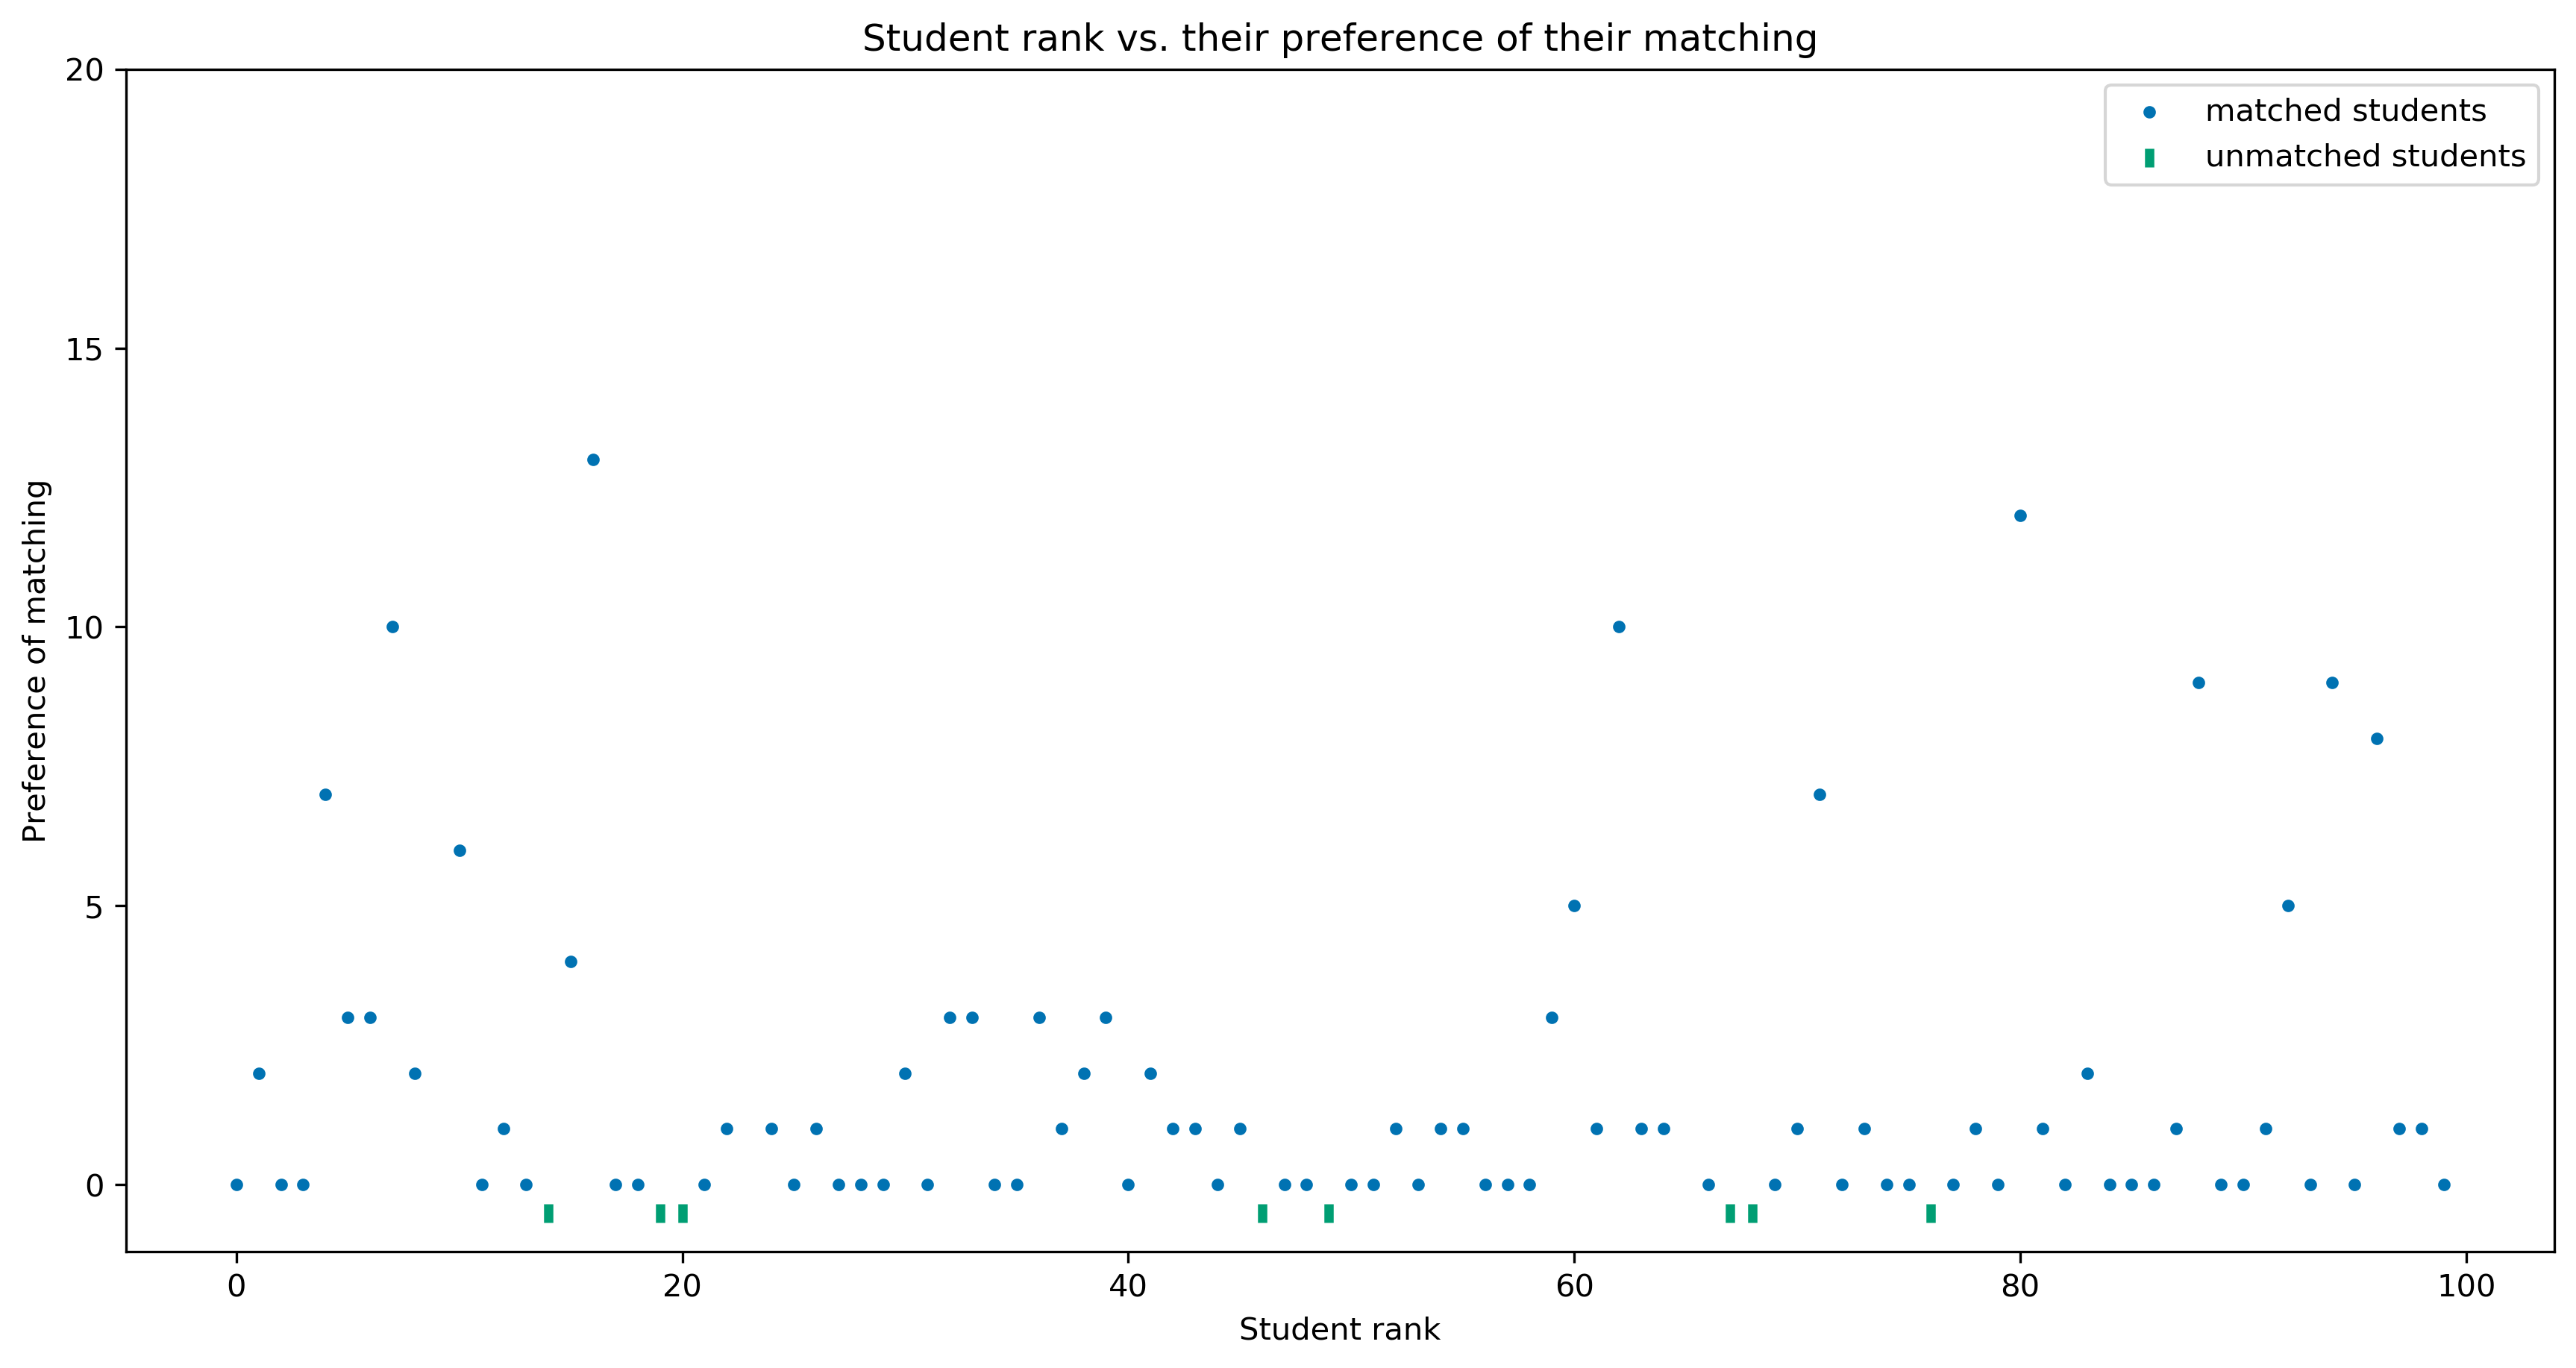

In [42]:
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)

ax.scatter(
    assigned_students["rank"],
    assigned_students["preference"],
    marker=".",
#     s=10,
    label="matched students",
)

ax.scatter(
    unassigned_students["rank"],
    [-0.5] * len(unassigned_students),
    marker="|",
    lw=3,
    label="unmatched students",
)

ax.set_yticks(range(0, 21, 5))
ax.set_xlabel("Student rank")
ax.set_ylabel("Preference of matching")
ax.set_title("Student rank vs. their preference of their matching")
ax.legend()


This is the kind of behaviour we want to see. There is a strong line along the bottom, as expected, since we know most students got their first choice. Then, the cloud of less-preferable matches only grows towards the bottom of the ranking.

This plot is also helpful when justifying an allocation to a student. Each student who has not been allocated their first $x$ choices has only not got one of those because all the space for those choices was taken up by the students who precede them in this plot.

In the case of students without a project (the green lines above), all of their choices were taken up by students who are ranked higher than them.

## Figuring out the remaining spaces

Alas, this is only a starting point. From here, adjustments can be made to the allocation (not recommended as this would break its mathematical soundness) or the unassigned students can be offered any project with space left over.

To figure out where there are spaces, we can use the `matching.Game` and the data we cleaned earlier.

In [43]:
project_with_space_names = [
    project.name
    for project in game.projects
    if len(project.matching) < project.capacity
] + list(unranked_projects)

supervisor_with_space_names = [
    supervisor.name
    for supervisor in game.supervisors
    if len(supervisor.matching) < supervisor.capacity
] + list(unranked_supervisors)


In [44]:
def get_number_of_matches(name, party, game):

    for player in vars(game)[party]:
        if player.name == name:
            return len(player.matching)

    return 0


def get_capacity(data, party, name):

    if party == "project":
        column = "project_code"
    else:
        column = "supervisor_name"

    return data[data[column] == name][f"{party}_capacity"].iloc[0]


In [45]:
projects_with_space = projects[
    (projects["project_code"].isin(project_with_space_names))
    & (projects["supervisor_name"].isin(supervisor_with_space_names))
]

projects_with_space["supervisor_capacity"] = projects_with_space[
    "supervisor_name"
].apply(lambda x: get_capacity(supervisors, "supervisor", x))
projects_with_space["project_matches"] = projects_with_space["project_code"].apply(
    lambda x: get_number_of_matches(x, "projects", game)
)
projects_with_space["supervisor_matches"] = projects_with_space[
    "supervisor_name"
].apply(lambda x: get_number_of_matches(x, "supervisors", game))

projects_with_space = projects_with_space[
    [
        "project_code",
        "project_capacity",
        "project_matches",
        "supervisor_name",
        "supervisor_capacity",
        "supervisor_matches",
    ]
]


In [46]:
# projects_with_space.to_csv("data/spaces.csv", index=False)
projects_with_space = projects_with_space.set_index(
    ["supervisor_name", "project_code"]
).sort_index()

projects_with_space


,,project_capacity,project_matches,supervisor_capacity,supervisor_matches
supervisor_name,project_code,,,,
L,L1,4,1,4,3
S,S1,8,5,8,7


In [47]:
unassigned_student_preferences = students.iloc[unassigned_students.index, :]

# assigned_students.to_csv("data/assigned.csv", index=False)
# unassigned_student_preferences.to_csv("data/unassigned.csv", index=False)
unassigned_student_preferences


,student_number,rank,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
8,190008,85,W1,X2,W0,N0,H2,Z1,X2,R2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,190018,94,W0,C1,D0,B0,D1,T1,C0,Y1,...,C2,I2,I0,R1,N2,I2,H1,NaN,NaN,NaN
21,190021,97,R1,V2,U0,N0,C0,D1,P3,F0,...,A2,O0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,190028,89,D2,E0,H2,Q0,T0,U2,Q0,I2,...,M1,G1,B0,E2,Q0,W0,R2,P1,NaN,NaN
30,190030,98,P2,R0,X1,X2,K1,R2,A0,Z1,...,H2,J2,P2,F0,N2,T0,T1,NaN,NaN,NaN
63,190063,95,N1,B1,I2,T2,C2,F1,K0,G1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,190074,87,F0,G1,U0,E2,Z1,O0,I1,K0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,190075,93,R0,H0,D2,U1,I2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
int_choices = [int(c) for c in choices]
frequency_of_project = students[int_choices].apply(pd.Series.value_counts).fillna(0).sum(axis=1).sort_values()

frequency_of_project

L1    12.0
J2    14.0
H0    14.0
A0    16.0
J0    16.0
Y1    17.0
Z1    17.0
C1    18.0
X1    18.0
G2    18.0
E2    18.0
M1    18.0
E0    19.0
Y0    19.0
X0    19.0
W1    19.0
Z0    19.0
B2    19.0
P0    19.0
P3    20.0
K2    20.0
F1    20.0
T0    20.0
R2    21.0
O0    21.0
V2    21.0
E1    21.0
V0    21.0
I0    22.0
K1    22.0
      ... 
S1    24.0
O1    24.0
D2    24.0
A2    24.0
L0    24.0
Q0    24.0
R1    24.0
K0    24.0
B0    24.0
J1    24.0
U0    25.0
A1    25.0
D0    25.0
N2    25.0
P2    25.0
C0    25.0
H1    25.0
I2    25.0
Y2    26.0
X2    26.0
T2    26.0
D1    27.0
W0    28.0
B1    28.0
V1    29.0
N0    30.0
H2    30.0
T1    31.0
N1    31.0
P1    32.0
Length: 69, dtype: float64

In [49]:
frequency_of_project_by_rank = (
    students[int_choices].apply(pd.Series.value_counts).fillna(0).sort_values(by=int_choices).head(10)
)
frequency_of_project_by_rank

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Z1,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N2,0.0,0.0,3.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,...,0.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
L1,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0
Z0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,2.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
P3,0.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,1.0,...,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
H2,0.0,1.0,2.0,0.0,1.0,2.0,2.0,2.0,2.0,1.0,...,3.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
U0,0.0,1.0,2.0,0.0,2.0,0.0,1.0,2.0,2.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
G0,0.0,1.0,2.0,2.0,1.0,3.0,0.0,1.0,0.0,1.0,...,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
N0,0.0,1.0,2.0,3.0,2.0,3.0,4.0,2.0,2.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
U2,0.0,2.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,3.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
